In [1]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import random
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import metrics
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import time
from utils import *

2026-01-16 21:55:29.092134: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 21:55:29.333625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 21:55:32.473400: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(f"TensorFlow / Keras Version: {tf.__version__}")

TensorFlow / Keras Version: 2.20.0


In [3]:
SEED = 28
seed_everthing(SEED)
gpu_growth()
strategy = get_strategy()

For reproducibility, everything seeded!
Enabled memory growth for 1 GPU(s)
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU strategy: MirroredStrategy
REPLICAS: 1


I0000 00:00:1768587938.516627   17832 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
AUTO = tf.data.AUTOTUNE
DATA_DIR = '../../../data/'
MODELS_DIR = '../../../models/'
IMAGE_SIZE = (256, 256)
MASK_SIZE = IMAGE_SIZE
SHUFFLE_SIZE = 1024
# === CELL 2: ALGORITHM CONFIGS ===
PENALIZED_F1_CONFIG = {'alpha_p': 0.2, 'stage': 7, 'K': 4}
ARCHITECTURE_CONFIG = {'arch_trials': 20, 'arch_epoch': 7}
MODEL_CONFIG = {'img_size': IMAGE_SIZE}

BATCH_SIZE_PER_REPLICA = 8
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
DATASET_CONFIG = {"shuffle": SHUFFLE_SIZE, "batch_size": GLOBAL_BATCH_SIZE, 'auto': AUTO}
print(f'Global Batch size: {GLOBAL_BATCH_SIZE}')

Global Batch size: 8


In [5]:
# Loading original class mapping
class_mapping_path = os.path.join(DATA_DIR, 'class_mapping.json')
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

print(class_mapping)

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2, 'Lung_Opacity': 3}


In [6]:
unhealthy_class_mapping_path = os.path.join(DATA_DIR, 'healthy_binary_mapping.json')
with open(unhealthy_class_mapping_path, 'r') as f:
    unhealthy_class_mapping = json.load(f)

print(unhealthy_class_mapping)

{'Healthy': 0, 'Unhealthy': 1}


In [7]:
all_files = sorted(tf.io.gfile.glob(os.path.join(DATA_DIR, 'tfrecords/*.tfrecord')))
sub_train_files = all_files[:3]
val_files = all_files[-1:]
print(
    f"Train files: {sub_train_files}\n"
    f"Val files: {val_files}"
)

Train files: ['../../../data/tfrecords/data_00.tfrecord', '../../../data/tfrecords/data_01.tfrecord', '../../../data/tfrecords/data_02.tfrecord']
Val files: ['../../../data/tfrecords/data_09.tfrecord']


In [8]:
parse_fn = make_parse_fn(image_size=IMAGE_SIZE, mask_size=MASK_SIZE)

In [9]:
def dataset(tfrecords, config=DATASET_CONFIG, is_training= True, image_augmentation=None):
    shuffle_size = config["shuffle"]
    batch_size = config["batch_size"]
    AUTO = config["auto"]
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads= AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(parse_fn, num_parallel_calls= AUTO)
    dataset = dataset.map(lung_roi_preprocess, num_parallel_calls=AUTO)
    dataset = dataset.map(remap_for_binary, num_parallel_calls=AUTO)
    
    if is_training:
        dataset = dataset.shuffle(shuffle_size)
        # 1. Batch the data FIRST
        dataset = dataset.batch(batch_size, drop_remainder= True)
        # 2. Apply augmentation to the entire batch SECOND
        if image_augmentation is not None:
            dataset = dataset.map(
                lambda x, y: (image_augmentation(x, training=True), y), 
                num_parallel_calls= AUTO
            )
    else:
        # For validation, just batch the data without augmenting
        dataset = dataset.batch(batch_size, drop_remainder= True)

    dataset = dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls= AUTO)
    # 3. Prefetch the augmented batches
    dataset = dataset.prefetch(AUTO)
    return dataset

In [10]:
sub_train_dataset = dataset(sub_train_files, is_training= True, image_augmentation=None)
val_dataset = dataset(val_files, is_training= False, image_augmentation=None)
print(f"Train and Validation datasets are created successfully !")

Train and Validation datasets are created successfully !


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.310451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0314343..1.7156335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2222912].


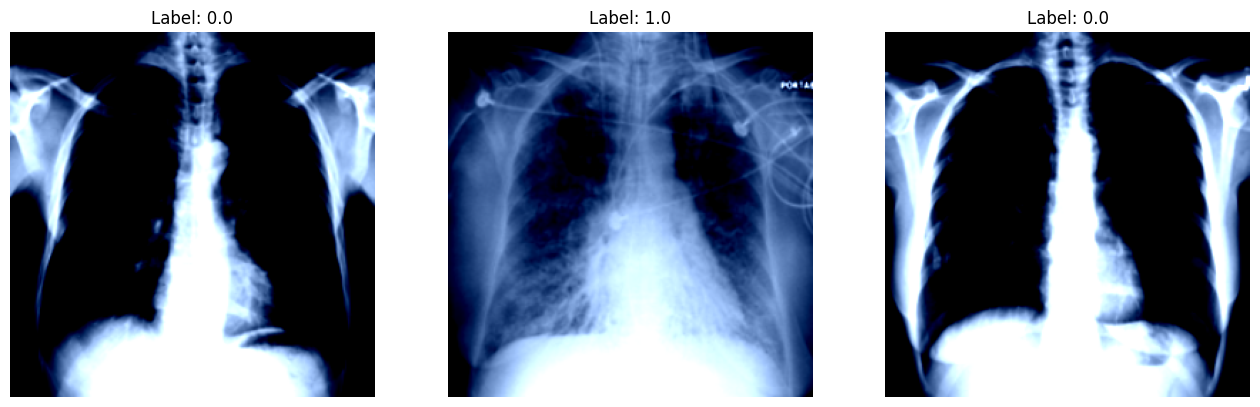

In [34]:
for img, label in sub_train_dataset.take(1):
    fig, axes = plt.subplots(1, 3, figsize= (16, 9))
    for i, ax in enumerate(axes):
        ax.imshow(img[i].numpy())
        ax.set_title(f"Label: {(label[i][0])}")
        ax.axis("off")
    plt.show()

In [11]:
optuna_steps = count_steps(sub_train_dataset)
validation_steps = count_steps(val_dataset)
print(
    f"Optuna Training Steps: {optuna_steps}\n"
    f"Validation Steps: {validation_steps}"
)

ARCHITECTURE_CONFIG['optuna_steps'] = int(optuna_steps)
ARCHITECTURE_CONFIG['validation_steps'] = int(validation_steps)

2026-01-16 21:55:59.225167: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144


Optuna Training Steps: 793
Validation Steps: 264


In [12]:
def architecture_hparams(trial):
    hparams = {}
    hparams["num_layers"] = trial.suggest_int("num_layers", 1, 3)
    first_unit = trial.suggest_categorical("first_unit", [256, 512, 1024])
    dense_units = [first_unit]
    
    # EACH LAYER: Randomly divide by 2 OR 4 (your brilliance!)
    for i in range(1, hparams["num_layers"]):
        divide_by = trial.suggest_categorical(f"divide_{i}", [2, 4])  # 2x OR 4x!
        next_unit = dense_units[-1] // divide_by
        next_unit = max(next_unit, 32)  # Minimum size
        dense_units.append(next_unit)
    hparams["dense_units"] = dense_units
    return hparams

In [13]:
def densenet_model(
    hparams, dropout_rate,
    config=MODEL_CONFIG
):
    
    img_size = config["img_size"]
    inputs = tfl.Input(shape= img_size + (3,))
    base_model = DenseNet121(
        name= 'densenet',
        weights= 'imagenet',
        include_top= False
    )
    base_model.trainable = False
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
    
    densenet = base_model(inputs, training= False)
    x = tfl.GlobalAveragePooling2D()(densenet)
    num_dense_layers = hparams["num_layers"]
    for i in range(num_dense_layers):
        units = hparams["dense_units"][i]
        x = tfl.Dense(units, activation= 'relu', name=f"head_dense_{i}")(x)
        if i == num_dense_layers - 1:
            head_dropout = tfl.Dropout(dropout_rate, name="head_dropout")
            x = head_dropout(x, training=True)

    outputs = tfl.Dense(1, activation= 'sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [14]:
def penalized_f1_score(history, config=PENALIZED_F1_CONFIG):

    
    """
    Your exact rolling window penalized F1 score function
    """
    alpha_p = config['alpha_p']
    stage_epochs = config['stage']
    K = config['K']

    
    val_prec = np.array(history.history["val_precision"])
    val_rec = np.array(history.history["val_recall"])
    val_f1 = np.array(2*(np.multiply(val_prec, val_rec)) / np.add(val_prec, val_rec))
    
    # Use last N epochs (adaptive for short architecture search)
    stage_epochs = min(stage_epochs, len(val_f1))
    # Rolling window average
    f1_roll = np.convolve(val_f1[-stage_epochs:], np.ones(K)/K, mode="valid")
    prec_roll = np.convolve(val_prec[-stage_epochs:], np.ones(K)/K, mode="valid")
    rec_roll = np.convolve(val_rec[-stage_epochs:], np.ones(K)/K, mode="valid")
        
    # Best epoch by F1
    idx = np.argmax(f1_roll)
        
    f1 = f1_roll[idx]
    prec = prec_roll[idx]
    rec = rec_roll[idx]
        
    # Your gap penalty
    gap_penalty = alpha_p * abs(prec - rec)
    score = f1 - gap_penalty
    
    return score, f1, prec, rec

In [15]:
def objective_architecture(trial, config=ARCHITECTURE_CONFIG):    
    print("="*180)
    print(f"Trial {trial.number + 1}/{config['arch_trials']} started...")
    arch_epoch = config['arch_epoch']
    optuna_steps = config['optuna_steps']
    validation_steps = config['validation_steps']
    model = None
    history = None
    callbacks = None
    lr = 3e-4
    try:
        with strategy.scope():
            loss = BinaryCrossentropy()
            optimizer = Adam(
                learning_rate=lr
            )
            metrics_list = [
                metrics.BinaryAccuracy(name='accuracy'),
                metrics.Precision(name='precision'),
                metrics.Recall(name='recall'),
                metrics.AUC(name='AUC')
            ]
            arch_hparams = architecture_hparams(trial)
            trial.set_user_attr("arch_hparams", arch_hparams)
            model = densenet_model(
                arch_hparams, dropout_rate=0.1, config=MODEL_CONFIG
            )
            model.compile(
                loss=loss,
                optimizer=optimizer,
                metrics=metrics_list
            )
            
        history = model.fit(
                sub_train_dataset.repeat(),
                validation_data=val_dataset.repeat(),
                epochs=arch_epoch,
                steps_per_epoch=optuna_steps,
                validation_steps=validation_steps
            )
        score, best_f1, best_prec, best_rec = penalized_f1_score(history, config=PENALIZED_F1_CONFIG)
        trial.set_user_attr("phase1_score", float(score))
        print(f"Penalized F1: {score:.4f}, Best F1: {best_f1:.4f}, P: {best_prec:.4f}, R: {best_rec:.4f}")
        return score
    finally:
        cleanup(model, history, callbacks)

In [16]:
# Create an Optuna study object to find the best hyperparameter configuration
storage_dir = "sqlite:///phase1_architecture/healthy_unhealthy-phase1_architecture.db"
study = optuna.create_study(
    direction= 'maximize',
    storage=storage_dir,
    load_if_exists=True
)
# Start the optimization process over a fixed number of trials
study.optimize(lambda trial: objective_architecture(
    trial, config=ARCHITECTURE_CONFIG), 
    n_trials=ARCHITECTURE_CONFIG['arch_trials'], gc_after_trial= True)

best_trial = study.best_trial 
best_hparams = best_trial.user_attrs.get("arch_hparams", None)

if best_hparams is None: 
    params = best_trial.params 
    # reconstruct dense_units from params (example) 
    num_layers = params["num_layers"] 
    first_unit = int(params["first_unit"]) 
    dense_units = [first_unit] 
    for i in range(1, num_layers):
        divide_by = int(params[f"divide_{i}"]) 
        dense_units.append(max(dense_units[-1] // divide_by, 32)) 
    best_hparams = { 
        "num_layers": num_layers, 
        "dense_units": dense_units,
    }

# collect metadata to save 
metadata = { 
    "best_trial_number": int(best_trial.number), 
    "best_value": float(best_trial.value), 
    "best_hparams": best_hparams, 
    "phase1_settings": { 
        "loss": "BinaryCrossentropy", 
        "optimizer": "Adam", 
        "lr": 3e-4, 
        "weight_decay": 0,
        "dropout_rate": 0.1
    }, 
    "timestamp": time.time(), 
    "seed": SEED
}


metadata_dir = "./phase1_architecture/healthy_unhealthy-best_architecture.json"
with open(metadata_dir, "w") as f:
    json.dump(metadata, f, indent=2)

[I 2026-01-16 21:56:29,423] A new study created in RDB with name: no-name-a40e818a-08d0-487f-8d7f-f1d805d62885


Trial 1/20 started...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',)

2026-01-16 21:56:43.943394: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2026-01-16 21:56:45.282790: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


793/793 ━━━━━━━━━━━━━━━━━━━━ 121s 136ms/step - AUC: 0.9047 - accuracy: 0.8348 - loss: 0.3891 - precision: 0.8557 - recall: 0.8198 - val_AUC: 0.9408 - val_accuracy: 0.8764 - val_loss: 0.3077 - val_precision: 0.8998 - val_recall: 0.8459
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9334 - accuracy: 0.8627 - loss: 0.3234 - precision: 0.8856 - recall: 0.8444 - val_AUC: 0.9483 - val_accuracy: 0.8736 - val_loss: 0.3095 - val_precision: 0.9365 - val_recall: 0.8002
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9432 - accuracy: 0.8761 - loss: 0.2992 - precision: 0.8962 - recall: 0.8608 - val_AUC: 0.9530 - val_accuracy: 0.8821 - val_loss: 0.2853 - val_precision: 0.9359 - val_recall: 0.8192
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9510 - accuracy: 0.8881 - loss: 0.2767 - precision: 0.9106 - recall: 0.8696 - val_AUC: 0.9544 - val_accuracy: 0.8821 - val_loss: 0.2896 - val_precision: 0.9475 - val_recall: 0.8078
Epoch 5/7
793/793 ━━━━━━━━━━━━

[I 2026-01-16 22:09:07,453] Trial 0 finished with value: 0.8478622470806698 and parameters: {'num_layers': 3, 'first_unit': 1024, 'divide_1': 4, 'divide_2': 2}. Best is trial 0 with value: 0.8478622470806698.


🧹 RAM Cleaned. Current usage: 3267.09 MB
Trial 2/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - AUC: 0.9026 - accuracy: 0.8287 - loss: 0.3921 - precision: 0.8539 - recall: 0.8080 - val_AUC: 0.9430 - val_accuracy: 0.8461 - val_loss: 0.3419 - val_precision: 0.9560 - val_recall: 0.7241
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9345 - accuracy: 0.8652 - loss: 0.3198 - precision: 0.8916 - recall: 0.8425 - val_AUC: 0.9451 - val_accuracy: 0.8679 - val_loss: 0.3290 - val_precision: 0.9416 - val_recall: 0.7831
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9466 - accuracy: 0.8785 - loss: 0.2897 - precision: 0.9023 - recall: 0.8587 - val_AUC: 0.9481 - val_accuracy: 0.8845 - val_loss: 0.2834 - val_precision: 0.9234 - val_recall: 0.8373
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9515 - accuracy: 0.8841 - loss: 0.2774 - precision: 0.9062 - recall: 0.8663 - val_AUC: 0.9503 - val_accuracy: 0.8864 - val_loss: 0.2960 - 

[I 2026-01-16 22:21:21,948] Trial 1 finished with value: 0.8732510207848887 and parameters: {'num_layers': 3, 'first_unit': 1024, 'divide_1': 4, 'divide_2': 2}. Best is trial 1 with value: 0.8732510207848887.


🧹 RAM Cleaned. Current usage: 3341.40 MB
Trial 3/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8722 - accuracy: 0.8012 - loss: 0.4414 - precision: 0.8275 - recall: 0.7762

2026-01-16 22:22:49.730288: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2026-01-16 22:22:49.731217: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']


793/793 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - AUC: 0.8976 - accuracy: 0.8239 - loss: 0.4024 - precision: 0.8467 - recall: 0.8069 - val_AUC: 0.9375 - val_accuracy: 0.8646 - val_loss: 0.3358 - val_precision: 0.8667 - val_recall: 0.8601
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 128ms/step - AUC: 0.9336 - accuracy: 0.8663 - loss: 0.3239 - precision: 0.8884 - recall: 0.8490 - val_AUC: 0.9479 - val_accuracy: 0.8291 - val_loss: 0.3820 - val_precision: 0.7654 - val_recall: 0.9467
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 142s 180ms/step - AUC: 0.9420 - accuracy: 0.8778 - loss: 0.3012 - precision: 0.9016 - recall: 0.8581 - val_AUC: 0.9509 - val_accuracy: 0.8646 - val_loss: 0.3408 - val_precision: 0.9548 - val_recall: 0.7640
Epoch 4/7
789/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9482 - accuracy: 0.8834 - loss: 0.2872 - precision: 0.9023 - recall: 0.8729

2026-01-16 22:28:38.049619: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - AUC: 0.9474 - accuracy: 0.8810 - loss: 0.2881 - precision: 0.9012 - recall: 0.8653 - val_AUC: 0.9489 - val_accuracy: 0.8755 - val_loss: 0.3173 - val_precision: 0.8512 - val_recall: 0.9087
Epoch 5/7
790/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9587 - accuracy: 0.8952 - loss: 0.2560 - precision: 0.9167 - recall: 0.8790

2026-01-16 22:30:20.761950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - AUC: 0.9559 - accuracy: 0.8908 - loss: 0.2649 - precision: 0.9088 - recall: 0.8776 - val_AUC: 0.9546 - val_accuracy: 0.8906 - val_loss: 0.2736 - val_precision: 0.9108 - val_recall: 0.8649
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9578 - accuracy: 0.8914 - loss: 0.2572 - precision: 0.9108 - recall: 0.8768 - val_AUC: 0.9543 - val_accuracy: 0.8759 - val_loss: 0.2934 - val_precision: 0.9519 - val_recall: 0.7907
Epoch 7/7
789/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9631 - accuracy: 0.8993 - loss: 0.2400 - precision: 0.9198 - recall: 0.8819

2026-01-16 22:33:44.991026: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9613 - accuracy: 0.9001 - loss: 0.2468 - precision: 0.9190 - recall: 0.8855 - val_AUC: 0.9559 - val_accuracy: 0.8821 - val_loss: 0.2983 - val_precision: 0.9506 - val_recall: 0.8049
Penalized F1: 0.8607, Best F1: 0.8754, P: 0.9161, R: 0.8423


[I 2026-01-16 22:34:10,868] Trial 2 finished with value: 0.8606800571052449 and parameters: {'num_layers': 3, 'first_unit': 256, 'divide_1': 4, 'divide_2': 2}. Best is trial 1 with value: 0.8732510207848887.


🧹 RAM Cleaned. Current usage: 3410.60 MB
Trial 4/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8700 - accuracy: 0.7864 - loss: 0.4400 - precision: 0.8039 - recall: 0.7851

2026-01-16 22:35:40.359833: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']


793/793 ━━━━━━━━━━━━━━━━━━━━ 110s 132ms/step - AUC: 0.8992 - accuracy: 0.8186 - loss: 0.3987 - precision: 0.8402 - recall: 0.8032 - val_AUC: 0.9393 - val_accuracy: 0.8651 - val_loss: 0.3400 - val_precision: 0.8426 - val_recall: 0.8963
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9384 - accuracy: 0.8740 - loss: 0.3120 - precision: 0.8967 - recall: 0.8570

2026-01-16 22:37:24.316705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 22:37:48.007052: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9365 - accuracy: 0.8692 - loss: 0.3162 - precision: 0.8928 - recall: 0.8499 - val_AUC: 0.9488 - val_accuracy: 0.8812 - val_loss: 0.2854 - val_precision: 0.9024 - val_recall: 0.8535
Epoch 3/7
789/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9469 - accuracy: 0.8795 - loss: 0.2889 - precision: 0.9034 - recall: 0.8613

2026-01-16 22:39:05.544620: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9469 - accuracy: 0.8795 - loss: 0.2889 - precision: 0.9034 - recall: 0.8613

2026-01-16 22:39:29.513215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 128ms/step - AUC: 0.9457 - accuracy: 0.8794 - loss: 0.2928 - precision: 0.9020 - recall: 0.8612 - val_AUC: 0.9492 - val_accuracy: 0.8854 - val_loss: 0.2865 - val_precision: 0.9140 - val_recall: 0.8497
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9524 - accuracy: 0.8898 - loss: 0.2715 - precision: 0.9109 - recall: 0.8743

2026-01-16 22:41:11.278006: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9512 - accuracy: 0.8876 - loss: 0.2767 - precision: 0.9077 - recall: 0.8721 - val_AUC: 0.9538 - val_accuracy: 0.8859 - val_loss: 0.2768 - val_precision: 0.9290 - val_recall: 0.8344
Epoch 5/7
789/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9524 - accuracy: 0.8842 - loss: 0.2753 - precision: 0.9041 - recall: 0.8721

2026-01-16 22:42:28.372794: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9524 - accuracy: 0.8843 - loss: 0.2753 - precision: 0.9041 - recall: 0.8720

2026-01-16 22:42:52.215290: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - AUC: 0.9559 - accuracy: 0.8886 - loss: 0.2647 - precision: 0.9104 - recall: 0.8708 - val_AUC: 0.9512 - val_accuracy: 0.8788 - val_loss: 0.3040 - val_precision: 0.9451 - val_recall: 0.8030
Epoch 6/7
789/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9605 - accuracy: 0.8957 - loss: 0.2495 - precision: 0.9172 - recall: 0.8806

2026-01-16 22:44:09.121284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9605 - accuracy: 0.8957 - loss: 0.2495 - precision: 0.9172 - recall: 0.8806

2026-01-16 22:44:33.186198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - AUC: 0.9585 - accuracy: 0.8972 - loss: 0.2546 - precision: 0.9159 - recall: 0.8831 - val_AUC: 0.9566 - val_accuracy: 0.8788 - val_loss: 0.3041 - val_precision: 0.9543 - val_recall: 0.7945
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9647 - accuracy: 0.9053 - loss: 0.2363 - precision: 0.9256 - recall: 0.8913

2026-01-16 22:46:14.925035: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9633 - accuracy: 0.9035 - loss: 0.2412 - precision: 0.9209 - recall: 0.8907 - val_AUC: 0.9568 - val_accuracy: 0.8939 - val_loss: 0.2610 - val_precision: 0.9131 - val_recall: 0.8696
Penalized F1: 0.8687, Best F1: 0.8764, P: 0.8970, R: 0.8585


[I 2026-01-16 22:46:16,351] Trial 3 finished with value: 0.8687250209612669 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 2}. Best is trial 1 with value: 0.8732510207848887.


🧹 RAM Cleaned. Current usage: 3491.70 MB
Trial 5/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8624 - accuracy: 0.7954 - loss: 0.4491 - precision: 0.8145 - recall: 0.7938

2026-01-16 22:48:10.685754: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - AUC: 0.9038 - accuracy: 0.8301 - loss: 0.3900 - precision: 0.8488 - recall: 0.8183 - val_AUC: 0.9404 - val_accuracy: 0.7803 - val_loss: 0.5049 - val_precision: 0.9742 - val_recall: 0.5737
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9362 - accuracy: 0.8718 - loss: 0.3162 - precision: 0.8956 - recall: 0.8532

2026-01-16 22:49:29.210486: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 22:49:53.114142: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9347 - accuracy: 0.8689 - loss: 0.3208 - precision: 0.8890 - recall: 0.8539 - val_AUC: 0.9495 - val_accuracy: 0.8859 - val_loss: 0.2998 - val_precision: 0.8994 - val_recall: 0.8677
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9475 - accuracy: 0.8802 - loss: 0.2887 - precision: 0.9043 - recall: 0.8633

2026-01-16 22:51:11.521068: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 22:51:35.255102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9448 - accuracy: 0.8759 - loss: 0.2966 - precision: 0.8982 - recall: 0.8581 - val_AUC: 0.9495 - val_accuracy: 0.8182 - val_loss: 0.3940 - val_precision: 0.7487 - val_recall: 0.9553
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9526 - accuracy: 0.8897 - loss: 0.2713 - precision: 0.9092 - recall: 0.8755

2026-01-16 22:52:54.141929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 22:53:17.629854: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9499 - accuracy: 0.8859 - loss: 0.2797 - precision: 0.9066 - recall: 0.8696 - val_AUC: 0.9537 - val_accuracy: 0.8925 - val_loss: 0.2785 - val_precision: 0.9128 - val_recall: 0.8668
Epoch 5/7
789/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9559 - accuracy: 0.8930 - loss: 0.2611 - precision: 0.9166 - recall: 0.8755

2026-01-16 22:54:35.781173: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9559 - accuracy: 0.8930 - loss: 0.2611 - precision: 0.9166 - recall: 0.8755

2026-01-16 22:54:59.813083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9546 - accuracy: 0.8890 - loss: 0.2677 - precision: 0.9105 - recall: 0.8718 - val_AUC: 0.9541 - val_accuracy: 0.8911 - val_loss: 0.2688 - val_precision: 0.9228 - val_recall: 0.8525
Epoch 6/7
790/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9579 - accuracy: 0.8957 - loss: 0.2559 - precision: 0.9148 - recall: 0.8829

2026-01-16 22:56:16.827085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9579 - accuracy: 0.8957 - loss: 0.2558 - precision: 0.9148 - recall: 0.8829

2026-01-16 22:56:41.076598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 128ms/step - AUC: 0.9595 - accuracy: 0.8961 - loss: 0.2521 - precision: 0.9144 - recall: 0.8824 - val_AUC: 0.9492 - val_accuracy: 0.8830 - val_loss: 0.2893 - val_precision: 0.9223 - val_recall: 0.8354
Epoch 7/7
789/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9621 - accuracy: 0.9023 - loss: 0.2407 - precision: 0.9221 - recall: 0.8880

2026-01-16 22:57:58.195791: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9621 - accuracy: 0.9023 - loss: 0.2407 - precision: 0.9220 - recall: 0.8880

2026-01-16 22:57:58.930347: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 22:58:22.509742: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 128ms/step - AUC: 0.9611 - accuracy: 0.9015 - loss: 0.2454 - precision: 0.9216 - recall: 0.8855 - val_AUC: 0.9549 - val_accuracy: 0.8897 - val_loss: 0.2746 - val_precision: 0.8873 - val_recall: 0.8915
Penalized F1: 0.8754, Best F1: 0.8854, P: 0.9113, R: 0.8616


[I 2026-01-16 22:58:23,933] Trial 4 finished with value: 0.8754455005614603 and parameters: {'num_layers': 3, 'first_unit': 256, 'divide_1': 2, 'divide_2': 2}. Best is trial 4 with value: 0.8754455005614603.


🧹 RAM Cleaned. Current usage: 3568.53 MB
Trial 6/20 started...
Epoch 1/7


2026-01-16 22:58:33.508259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8728 - accuracy: 0.7967 - loss: 0.4396 - precision: 0.8183 - recall: 0.7945

2026-01-16 22:59:51.651151: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 22:59:51.855895: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 22:59:51.856078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

793/793 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - AUC: 0.9009 - accuracy: 0.8258 - loss: 0.3946 - precision: 0.8489 - recall: 0.8084 - val_AUC: 0.9449 - val_accuracy: 0.8774 - val_loss: 0.3110 - val_precision: 0.9082 - val_recall: 0.8382
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9385 - accuracy: 0.8741 - loss: 0.3116 - precision: 0.8984 - recall: 0.8570

2026-01-16 23:01:37.034374: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:02:00.506203: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9369 - accuracy: 0.8685 - loss: 0.3166 - precision: 0.8912 - recall: 0.8505 - val_AUC: 0.9499 - val_accuracy: 0.8807 - val_loss: 0.3097 - val_precision: 0.8780 - val_recall: 0.8830
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - AUC: 0.9464 - accuracy: 0.8796 - loss: 0.2892 - precision: 0.9046 - recall: 0.8585

2026-01-16 23:03:21.323854: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:03:45.254541: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 105s 132ms/step - AUC: 0.9448 - accuracy: 0.8774 - loss: 0.2950 - precision: 0.9013 - recall: 0.8575 - val_AUC: 0.9515 - val_accuracy: 0.8849 - val_loss: 0.3114 - val_precision: 0.9391 - val_recall: 0.8221
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - AUC: 0.9513 - accuracy: 0.8853 - loss: 0.2770 - precision: 0.9032 - recall: 0.8732

2026-01-16 23:05:07.812294: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:05:07.812438: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:05:32.282150: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

793/793 ━━━━━━━━━━━━━━━━━━━━ 107s 135ms/step - AUC: 0.9501 - accuracy: 0.8824 - loss: 0.2800 - precision: 0.9034 - recall: 0.8661 - val_AUC: 0.9539 - val_accuracy: 0.8958 - val_loss: 0.2813 - val_precision: 0.9143 - val_recall: 0.8725
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9573 - accuracy: 0.8982 - loss: 0.2543 - precision: 0.9277 - recall: 0.8736

2026-01-16 23:06:52.132672: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:07:15.594281: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9562 - accuracy: 0.8933 - loss: 0.2595 - precision: 0.9173 - recall: 0.8730 - val_AUC: 0.9548 - val_accuracy: 0.8925 - val_loss: 0.2693 - val_precision: 0.9153 - val_recall: 0.8639
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9575 - accuracy: 0.8969 - loss: 0.2560 - precision: 0.9249 - recall: 0.8734

2026-01-16 23:08:35.616589: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:08:59.348143: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9609 - accuracy: 0.9020 - loss: 0.2470 - precision: 0.9238 - recall: 0.8840 - val_AUC: 0.9515 - val_accuracy: 0.8821 - val_loss: 0.2922 - val_precision: 0.8652 - val_recall: 0.9039
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9644 - accuracy: 0.9087 - loss: 0.2352 - precision: 0.9309 - recall: 0.8893

2026-01-16 23:10:18.975696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:10:19.251317: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:10:19.251520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9631 - accuracy: 0.9053 - loss: 0.2386 - precision: 0.9289 - recall: 0.8852 - val_AUC: 0.9574 - val_accuracy: 0.8755 - val_loss: 0.2909 - val_precision: 0.9657 - val_recall: 0.7774
Penalized F1: 0.8771, Best F1: 0.8857, P: 0.9085, R: 0.8656


[I 2026-01-16 23:11:01,516] Trial 5 finished with value: 0.8770811783645466 and parameters: {'num_layers': 3, 'first_unit': 1024, 'divide_1': 2, 'divide_2': 4}. Best is trial 5 with value: 0.8770811783645466.


🧹 RAM Cleaned. Current usage: 3621.70 MB
Trial 7/20 started...


2026-01-16 23:11:05.265293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:11:05.265536: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8681 - accuracy: 0.7904 - loss: 0.4473 - precision: 0.8114 - recall: 0.7860

2026-01-16 23:12:29.171163: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:12:55.667971: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - AUC: 0.9050 - accuracy: 0.8271 - loss: 0.3880 - precision: 0.8467 - recall: 0.8140 - val_AUC: 0.9431 - val_accuracy: 0.8617 - val_loss: 0.3293 - val_precision: 0.9428 - val_recall: 0.7688
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9327 - accuracy: 0.8666 - loss: 0.3269 - precision: 0.8885 - recall: 0.8541

2026-01-16 23:14:15.296594: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:14:38.979875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9343 - accuracy: 0.8662 - loss: 0.3227 - precision: 0.8844 - recall: 0.8535 - val_AUC: 0.9496 - val_accuracy: 0.8816 - val_loss: 0.2892 - val_precision: 0.9238 - val_recall: 0.8306
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9494 - accuracy: 0.8883 - loss: 0.2816 - precision: 0.9069 - recall: 0.8740

2026-01-16 23:15:57.432585: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:16:21.351533: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9463 - accuracy: 0.8838 - loss: 0.2910 - precision: 0.9029 - recall: 0.8697 - val_AUC: 0.9475 - val_accuracy: 0.8651 - val_loss: 0.3164 - val_precision: 0.8342 - val_recall: 0.9096
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9522 - accuracy: 0.8837 - loss: 0.2753 - precision: 0.9016 - recall: 0.8726

2026-01-16 23:17:41.378982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:18:04.772674: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9475 - accuracy: 0.8785 - loss: 0.2888 - precision: 0.8952 - recall: 0.8671 - val_AUC: 0.9542 - val_accuracy: 0.8916 - val_loss: 0.2706 - val_precision: 0.8990 - val_recall: 0.8811
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9561 - accuracy: 0.8957 - loss: 0.2632 - precision: 0.9094 - recall: 0.8892

2026-01-16 23:19:23.180793: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:19:46.796263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9532 - accuracy: 0.8909 - loss: 0.2722 - precision: 0.9062 - recall: 0.8809 - val_AUC: 0.9550 - val_accuracy: 0.8911 - val_loss: 0.2689 - val_precision: 0.8936 - val_recall: 0.8868
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9597 - accuracy: 0.8973 - loss: 0.2511 - precision: 0.9184 - recall: 0.8794

2026-01-16 23:21:06.193039: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:21:29.732512: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9580 - accuracy: 0.8947 - loss: 0.2584 - precision: 0.9110 - recall: 0.8834 - val_AUC: 0.9557 - val_accuracy: 0.8935 - val_loss: 0.2656 - val_precision: 0.9267 - val_recall: 0.8535
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9632 - accuracy: 0.8997 - loss: 0.2398 - precision: 0.9183 - recall: 0.8862

2026-01-16 23:22:48.224558: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9586 - accuracy: 0.8933 - loss: 0.2559 - precision: 0.9089 - recall: 0.8827 - val_AUC: 0.9556 - val_accuracy: 0.8878 - val_loss: 0.2672 - val_precision: 0.9302 - val_recall: 0.8373
Penalized F1: 0.8780, Best F1: 0.8875, P: 0.9124, R: 0.8647


[I 2026-01-16 23:23:13,830] Trial 6 finished with value: 0.8779559507335967 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 6 with value: 0.8779559507335967.


🧹 RAM Cleaned. Current usage: 3716.94 MB
Trial 8/20 started...


2026-01-16 23:23:17.684928: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:23:17.685206: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8669 - accuracy: 0.7891 - loss: 0.4452 - precision: 0.8085 - recall: 0.7828

2026-01-16 23:24:42.366824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:25:09.210336: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 110s 133ms/step - AUC: 0.9033 - accuracy: 0.8290 - loss: 0.3902 - precision: 0.8503 - recall: 0.8139 - val_AUC: 0.9426 - val_accuracy: 0.8731 - val_loss: 0.3124 - val_precision: 0.8669 - val_recall: 0.8801
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9372 - accuracy: 0.8676 - loss: 0.3164 - precision: 0.8857 - recall: 0.8578

2026-01-16 23:26:26.136761: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:26:49.702527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 100s 127ms/step - AUC: 0.9383 - accuracy: 0.8689 - loss: 0.3138 - precision: 0.8862 - recall: 0.8571 - val_AUC: 0.9499 - val_accuracy: 0.8783 - val_loss: 0.2920 - val_precision: 0.9278 - val_recall: 0.8192
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - AUC: 0.9437 - accuracy: 0.8771 - loss: 0.2988 - precision: 0.8942 - recall: 0.8697

2026-01-16 23:28:04.920939: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:28:28.555597: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 99s 125ms/step - AUC: 0.9430 - accuracy: 0.8745 - loss: 0.3016 - precision: 0.8907 - recall: 0.8642 - val_AUC: 0.9528 - val_accuracy: 0.8584 - val_loss: 0.3314 - val_precision: 0.8107 - val_recall: 0.9334
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9535 - accuracy: 0.8874 - loss: 0.2717 - precision: 0.8998 - recall: 0.8820

2026-01-16 23:29:47.461113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:30:11.084120: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9502 - accuracy: 0.8827 - loss: 0.2812 - precision: 0.8981 - recall: 0.8730 - val_AUC: 0.9520 - val_accuracy: 0.8906 - val_loss: 0.2760 - val_precision: 0.8996 - val_recall: 0.8782
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9576 - accuracy: 0.8930 - loss: 0.2588 - precision: 0.9124 - recall: 0.8804

2026-01-16 23:31:30.267932: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:31:53.606144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - AUC: 0.9532 - accuracy: 0.8881 - loss: 0.2729 - precision: 0.9055 - recall: 0.8758 - val_AUC: 0.9557 - val_accuracy: 0.8807 - val_loss: 0.2919 - val_precision: 0.9494 - val_recall: 0.8030
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9582 - accuracy: 0.8923 - loss: 0.2584 - precision: 0.9133 - recall: 0.8792

2026-01-16 23:33:10.589933: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - AUC: 0.9579 - accuracy: 0.8933 - loss: 0.2588 - precision: 0.9103 - recall: 0.8813 - val_AUC: 0.9560 - val_accuracy: 0.8883 - val_loss: 0.2650 - val_precision: 0.9188 - val_recall: 0.8506
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9622 - accuracy: 0.9008 - loss: 0.2440 - precision: 0.9151 - recall: 0.8909

2026-01-16 23:34:53.088755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:35:16.697084: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9597 - accuracy: 0.9009 - loss: 0.2514 - precision: 0.9164 - recall: 0.8900 - val_AUC: 0.9560 - val_accuracy: 0.8864 - val_loss: 0.2759 - val_precision: 0.8765 - val_recall: 0.8982
Penalized F1: 0.8717, Best F1: 0.8824, P: 0.9111, R: 0.8575


[I 2026-01-16 23:35:18,560] Trial 7 finished with value: 0.8716634978471052 and parameters: {'num_layers': 1, 'first_unit': 512}. Best is trial 6 with value: 0.8779559507335967.


🧹 RAM Cleaned. Current usage: 3760.41 MB
Trial 9/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8632 - accuracy: 0.7808 - loss: 0.4488 - precision: 0.8052 - recall: 0.7664

2026-01-16 23:36:47.490882: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:36:50.723056: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:36:50.723220: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

793/793 ━━━━━━━━━━━━━━━━━━━━ 111s 134ms/step - AUC: 0.8978 - accuracy: 0.8206 - loss: 0.4003 - precision: 0.8467 - recall: 0.7989 - val_AUC: 0.9385 - val_accuracy: 0.8504 - val_loss: 0.3477 - val_precision: 0.9465 - val_recall: 0.7412
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9345 - accuracy: 0.8720 - loss: 0.3192 - precision: 0.8997 - recall: 0.8517

2026-01-16 23:38:32.777414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:38:57.028346: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9300 - accuracy: 0.8673 - loss: 0.3293 - precision: 0.8952 - recall: 0.8430 - val_AUC: 0.9488 - val_accuracy: 0.8542 - val_loss: 0.3443 - val_precision: 0.8058 - val_recall: 0.9315
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9434 - accuracy: 0.8765 - loss: 0.3004 - precision: 0.8971 - recall: 0.8635

2026-01-16 23:40:13.523799: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:40:37.689872: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - AUC: 0.9432 - accuracy: 0.8770 - loss: 0.2998 - precision: 0.8989 - recall: 0.8596 - val_AUC: 0.9524 - val_accuracy: 0.8878 - val_loss: 0.2761 - val_precision: 0.9145 - val_recall: 0.8544
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9504 - accuracy: 0.8848 - loss: 0.2787 - precision: 0.9099 - recall: 0.8664

2026-01-16 23:41:56.927414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:42:20.441268: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9503 - accuracy: 0.8852 - loss: 0.2794 - precision: 0.9077 - recall: 0.8669 - val_AUC: 0.9520 - val_accuracy: 0.8542 - val_loss: 0.3780 - val_precision: 0.9732 - val_recall: 0.7269
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9549 - accuracy: 0.8927 - loss: 0.2645 - precision: 0.9212 - recall: 0.8702

2026-01-16 23:43:39.683520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:44:03.275081: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9548 - accuracy: 0.8912 - loss: 0.2649 - precision: 0.9130 - recall: 0.8736 - val_AUC: 0.9549 - val_accuracy: 0.8883 - val_loss: 0.2713 - val_precision: 0.9330 - val_recall: 0.8354
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9586 - accuracy: 0.8964 - loss: 0.2536 - precision: 0.9206 - recall: 0.8787

2026-01-16 23:45:21.151570: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:45:44.966741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9582 - accuracy: 0.8960 - loss: 0.2551 - precision: 0.9188 - recall: 0.8769 - val_AUC: 0.9562 - val_accuracy: 0.8920 - val_loss: 0.2626 - val_precision: 0.9238 - val_recall: 0.8535
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9622 - accuracy: 0.9013 - loss: 0.2416 - precision: 0.9220 - recall: 0.8862

2026-01-16 23:47:03.897041: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:47:27.464913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9615 - accuracy: 0.9031 - loss: 0.2440 - precision: 0.9243 - recall: 0.8859 - val_AUC: 0.9543 - val_accuracy: 0.8878 - val_loss: 0.2784 - val_precision: 0.9367 - val_recall: 0.8306
Penalized F1: 0.8474, Best F1: 0.8711, P: 0.9361, R: 0.8176


[I 2026-01-16 23:47:29,716] Trial 8 finished with value: 0.8473920125676994 and parameters: {'num_layers': 3, 'first_unit': 512, 'divide_1': 4, 'divide_2': 4}. Best is trial 6 with value: 0.8779559507335967.


🧹 RAM Cleaned. Current usage: 3836.96 MB
Trial 10/20 started...
Epoch 1/7


2026-01-16 23:47:40.830493: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:47:40.830634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - AUC: 0.8788 - accuracy: 0.8034 - loss: 0.4319 - precision: 0.8183 - recall: 0.8008

2026-01-16 23:49:01.065269: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:49:27.865197: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 113s 135ms/step - AUC: 0.9043 - accuracy: 0.8261 - loss: 0.3890 - precision: 0.8454 - recall: 0.8138 - val_AUC: 0.9422 - val_accuracy: 0.8438 - val_loss: 0.3578 - val_precision: 0.9581 - val_recall: 0.7174
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9381 - accuracy: 0.8731 - loss: 0.3115 - precision: 0.8975 - recall: 0.8562

2026-01-16 23:50:47.940589: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:51:11.784603: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9385 - accuracy: 0.8714 - loss: 0.3112 - precision: 0.8930 - recall: 0.8545 - val_AUC: 0.9479 - val_accuracy: 0.8722 - val_loss: 0.3104 - val_precision: 0.9353 - val_recall: 0.7983
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9503 - accuracy: 0.8840 - loss: 0.2783 - precision: 0.9030 - recall: 0.8727

2026-01-16 23:52:31.772266: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:52:32.080568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:52:32.080740: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9467 - accuracy: 0.8818 - loss: 0.2898 - precision: 0.9030 - recall: 0.8651 - val_AUC: 0.9528 - val_accuracy: 0.8797 - val_loss: 0.2908 - val_precision: 0.8600 - val_recall: 0.9058
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9548 - accuracy: 0.8930 - loss: 0.2656 - precision: 0.9108 - recall: 0.8808

2026-01-16 23:54:15.302379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:54:39.375909: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9522 - accuracy: 0.8875 - loss: 0.2745 - precision: 0.9082 - recall: 0.8712 - val_AUC: 0.9545 - val_accuracy: 0.8958 - val_loss: 0.2684 - val_precision: 0.9210 - val_recall: 0.8649
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9584 - accuracy: 0.8892 - loss: 0.2565 - precision: 0.9111 - recall: 0.8762

2026-01-16 23:55:58.906615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:56:23.334971: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9585 - accuracy: 0.8928 - loss: 0.2559 - precision: 0.9104 - recall: 0.8800 - val_AUC: 0.9480 - val_accuracy: 0.8764 - val_loss: 0.3022 - val_precision: 0.8591 - val_recall: 0.8991
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9607 - accuracy: 0.9064 - loss: 0.2459 - precision: 0.9268 - recall: 0.8900

2026-01-16 23:57:43.076797: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:58:07.122472: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9598 - accuracy: 0.9032 - loss: 0.2501 - precision: 0.9227 - recall: 0.8879 - val_AUC: 0.9569 - val_accuracy: 0.8845 - val_loss: 0.2780 - val_precision: 0.9468 - val_recall: 0.8135
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9674 - accuracy: 0.9147 - loss: 0.2205 - precision: 0.9328 - recall: 0.9010

2026-01-16 23:59:26.508417: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-16 23:59:50.125869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9656 - accuracy: 0.9067 - loss: 0.2301 - precision: 0.9245 - recall: 0.8930 - val_AUC: 0.9575 - val_accuracy: 0.8954 - val_loss: 0.2621 - val_precision: 0.9287 - val_recall: 0.8554
Penalized F1: 0.8730, Best F1: 0.8841, P: 0.9139, R: 0.8582


[I 2026-01-16 23:59:54,285] Trial 9 finished with value: 0.872959718140697 and parameters: {'num_layers': 2, 'first_unit': 1024, 'divide_1': 4}. Best is trial 6 with value: 0.8779559507335967.


🧹 RAM Cleaned. Current usage: 3894.18 MB
Trial 11/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8784 - accuracy: 0.8010 - loss: 0.4390 - precision: 0.8177 - recall: 0.8029

2026-01-17 00:01:24.556741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:01:24.817214: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2026-01-17 00:01:51.506709: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 111s 134ms/step - AUC: 0.9050 - accuracy: 0.8291 - loss: 0.3896 - precision: 0.8463 - recall: 0.8195 - val_AUC: 0.9441 - val_accuracy: 0.8750 - val_loss: 0.3081 - val_precision: 0.8660 - val_recall: 0.8858
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9393 - accuracy: 0.8708 - loss: 0.3094 - precision: 0.8859 - recall: 0.8626

2026-01-17 00:03:08.803072: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:03:32.745011: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 128ms/step - AUC: 0.9380 - accuracy: 0.8681 - loss: 0.3148 - precision: 0.8832 - recall: 0.8593 - val_AUC: 0.9495 - val_accuracy: 0.8840 - val_loss: 0.2891 - val_precision: 0.8967 - val_recall: 0.8668
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9459 - accuracy: 0.8797 - loss: 0.2929 - precision: 0.8959 - recall: 0.8689

2026-01-17 00:04:49.565225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:05:13.793051: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - AUC: 0.9449 - accuracy: 0.8761 - loss: 0.2965 - precision: 0.8946 - recall: 0.8630 - val_AUC: 0.9522 - val_accuracy: 0.8632 - val_loss: 0.3282 - val_precision: 0.9601 - val_recall: 0.7564
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9456 - accuracy: 0.8842 - loss: 0.2948 - precision: 0.9050 - recall: 0.8686

2026-01-17 00:06:32.491696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:06:56.473007: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - AUC: 0.9447 - accuracy: 0.8813 - loss: 0.2965 - precision: 0.9003 - recall: 0.8672 - val_AUC: 0.9507 - val_accuracy: 0.8835 - val_loss: 0.2920 - val_precision: 0.9380 - val_recall: 0.8202
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9547 - accuracy: 0.8910 - loss: 0.2676 - precision: 0.9111 - recall: 0.8765

2026-01-17 00:08:14.760858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:08:39.107928: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - AUC: 0.9532 - accuracy: 0.8878 - loss: 0.2726 - precision: 0.9061 - recall: 0.8742 - val_AUC: 0.9549 - val_accuracy: 0.8902 - val_loss: 0.2731 - val_precision: 0.8852 - val_recall: 0.8953
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9563 - accuracy: 0.8917 - loss: 0.2617 - precision: 0.9133 - recall: 0.8772

2026-01-17 00:09:56.054431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:10:20.126497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - AUC: 0.9566 - accuracy: 0.8908 - loss: 0.2625 - precision: 0.9097 - recall: 0.8763 - val_AUC: 0.9561 - val_accuracy: 0.8868 - val_loss: 0.2778 - val_precision: 0.9394 - val_recall: 0.8259
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9601 - accuracy: 0.8958 - loss: 0.2498 - precision: 0.9143 - recall: 0.8832

2026-01-17 00:11:39.060173: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:12:02.516120: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9587 - accuracy: 0.8923 - loss: 0.2556 - precision: 0.9109 - recall: 0.8786 - val_AUC: 0.9581 - val_accuracy: 0.8944 - val_loss: 0.2570 - val_precision: 0.9165 - val_recall: 0.8668
Penalized F1: 0.8703, Best F1: 0.8838, P: 0.9198, R: 0.8520


[I 2026-01-17 00:12:04,694] Trial 10 finished with value: 0.8702849583378686 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 6 with value: 0.8779559507335967.


🧹 RAM Cleaned. Current usage: 3961.54 MB
Trial 12/20 started...


2026-01-17 00:12:08.462624: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:12:08.462845: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8720 - accuracy: 0.7910 - loss: 0.4437 - precision: 0.8131 - recall: 0.7827

2026-01-17 00:13:33.757522: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:14:00.496557: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - AUC: 0.9051 - accuracy: 0.8277 - loss: 0.3883 - precision: 0.8474 - recall: 0.8148 - val_AUC: 0.9422 - val_accuracy: 0.8731 - val_loss: 0.3086 - val_precision: 0.9160 - val_recall: 0.8202
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9378 - accuracy: 0.8705 - loss: 0.3148 - precision: 0.8903 - recall: 0.8582

2026-01-17 00:15:18.293601: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:15:41.735258: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 128ms/step - AUC: 0.9357 - accuracy: 0.8671 - loss: 0.3200 - precision: 0.8853 - recall: 0.8549 - val_AUC: 0.9485 - val_accuracy: 0.8693 - val_loss: 0.3217 - val_precision: 0.9553 - val_recall: 0.7735
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9443 - accuracy: 0.8757 - loss: 0.2962 - precision: 0.8950 - recall: 0.8648

2026-01-17 00:16:58.556192: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:17:22.683751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - AUC: 0.9431 - accuracy: 0.8736 - loss: 0.3001 - precision: 0.8893 - recall: 0.8639 - val_AUC: 0.9507 - val_accuracy: 0.7415 - val_loss: 0.5193 - val_precision: 0.6624 - val_recall: 0.9800
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9486 - accuracy: 0.8841 - loss: 0.2853 - precision: 0.8980 - recall: 0.8770

2026-01-17 00:18:41.280391: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:19:04.955456: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9492 - accuracy: 0.8849 - loss: 0.2838 - precision: 0.9021 - recall: 0.8730 - val_AUC: 0.9539 - val_accuracy: 0.8830 - val_loss: 0.2856 - val_precision: 0.8641 - val_recall: 0.9077
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9526 - accuracy: 0.8864 - loss: 0.2721 - precision: 0.9022 - recall: 0.8754

2026-01-17 00:20:23.437892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:20:47.635317: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - AUC: 0.9529 - accuracy: 0.8854 - loss: 0.2733 - precision: 0.9012 - recall: 0.8752 - val_AUC: 0.9543 - val_accuracy: 0.8419 - val_loss: 0.4007 - val_precision: 0.9799 - val_recall: 0.6965
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9557 - accuracy: 0.8883 - loss: 0.2666 - precision: 0.9073 - recall: 0.8781

2026-01-17 00:22:05.270572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:22:29.253506: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9574 - accuracy: 0.8925 - loss: 0.2592 - precision: 0.9076 - recall: 0.8827 - val_AUC: 0.9568 - val_accuracy: 0.8958 - val_loss: 0.2649 - val_precision: 0.8991 - val_recall: 0.8906
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9589 - accuracy: 0.8938 - loss: 0.2538 - precision: 0.9115 - recall: 0.8830

2026-01-17 00:23:47.584844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:24:11.822105: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - AUC: 0.9600 - accuracy: 0.8977 - loss: 0.2513 - precision: 0.9160 - recall: 0.8840 - val_AUC: 0.9567 - val_accuracy: 0.8935 - val_loss: 0.2615 - val_precision: 0.9206 - val_recall: 0.8601
Penalized F1: 0.8555, Best F1: 0.8709, P: 0.9159, R: 0.8387


[I 2026-01-17 00:24:14,089] Trial 11 finished with value: 0.8555033373077778 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 6 with value: 0.8779559507335967.


🧹 RAM Cleaned. Current usage: 4011.58 MB
Trial 13/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.8785 - accuracy: 0.8027 - loss: 0.4281 - precision: 0.8232 - recall: 0.7891

2026-01-17 00:25:44.198857: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:26:10.971629: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - AUC: 0.9071 - accuracy: 0.8290 - loss: 0.3830 - precision: 0.8511 - recall: 0.8125 - val_AUC: 0.9466 - val_accuracy: 0.8835 - val_loss: 0.2956 - val_precision: 0.8935 - val_recall: 0.8696
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9388 - accuracy: 0.8698 - loss: 0.3094 - precision: 0.8956 - recall: 0.8513

2026-01-17 00:27:28.900715: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:27:52.661251: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9401 - accuracy: 0.8726 - loss: 0.3079 - precision: 0.8946 - recall: 0.8555 - val_AUC: 0.9476 - val_accuracy: 0.8622 - val_loss: 0.3209 - val_precision: 0.9481 - val_recall: 0.7650
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9481 - accuracy: 0.8840 - loss: 0.2865 - precision: 0.9070 - recall: 0.8676

2026-01-17 00:29:10.588597: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:29:34.896827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9450 - accuracy: 0.8791 - loss: 0.2957 - precision: 0.8991 - recall: 0.8639 - val_AUC: 0.9514 - val_accuracy: 0.8821 - val_loss: 0.2940 - val_precision: 0.8901 - val_recall: 0.8706
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9571 - accuracy: 0.8955 - loss: 0.2585 - precision: 0.9174 - recall: 0.8801

2026-01-17 00:30:54.650202: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:31:18.373598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - AUC: 0.9534 - accuracy: 0.8903 - loss: 0.2706 - precision: 0.9105 - recall: 0.8746 - val_AUC: 0.9551 - val_accuracy: 0.8949 - val_loss: 0.2743 - val_precision: 0.8997 - val_recall: 0.8877
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9577 - accuracy: 0.8993 - loss: 0.2558 - precision: 0.9221 - recall: 0.8805

2026-01-17 00:32:38.266962: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:33:02.476378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9579 - accuracy: 0.8958 - loss: 0.2579 - precision: 0.9159 - recall: 0.8800 - val_AUC: 0.9493 - val_accuracy: 0.8835 - val_loss: 0.2800 - val_precision: 0.8927 - val_recall: 0.8706
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9638 - accuracy: 0.9014 - loss: 0.2386 - precision: 0.9186 - recall: 0.8898

2026-01-17 00:34:20.584711: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:34:44.663677: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9624 - accuracy: 0.9004 - loss: 0.2438 - precision: 0.9167 - recall: 0.8888 - val_AUC: 0.9572 - val_accuracy: 0.8939 - val_loss: 0.2637 - val_precision: 0.8980 - val_recall: 0.8877
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9663 - accuracy: 0.9060 - loss: 0.2288 - precision: 0.9232 - recall: 0.8941

2026-01-17 00:36:03.728844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:36:28.267745: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9652 - accuracy: 0.9083 - loss: 0.2327 - precision: 0.9251 - recall: 0.8958 - val_AUC: 0.9574 - val_accuracy: 0.8935 - val_loss: 0.2670 - val_precision: 0.8918 - val_recall: 0.8944
Penalized F1: 0.8882, Best F1: 0.8903, P: 0.8956, R: 0.8851


[I 2026-01-17 00:36:30,594] Trial 12 finished with value: 0.8881901409353111 and parameters: {'num_layers': 2, 'first_unit': 1024, 'divide_1': 2}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4076.39 MB
Trial 14/20 started...


2026-01-17 00:36:34.603821: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:36:34.604014: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8857 - accuracy: 0.8073 - loss: 0.4226 - precision: 0.8288 - recall: 0.7946

2026-01-17 00:38:00.127377: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:38:27.613600: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - AUC: 0.9072 - accuracy: 0.8301 - loss: 0.3851 - precision: 0.8504 - recall: 0.8163 - val_AUC: 0.9407 - val_accuracy: 0.8736 - val_loss: 0.3144 - val_precision: 0.8928 - val_recall: 0.8478
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9391 - accuracy: 0.8714 - loss: 0.3081 - precision: 0.8957 - recall: 0.8549

2026-01-17 00:39:45.693341: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:40:10.072135: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9368 - accuracy: 0.8663 - loss: 0.3157 - precision: 0.8887 - recall: 0.8487 - val_AUC: 0.9453 - val_accuracy: 0.8561 - val_loss: 0.3403 - val_precision: 0.9516 - val_recall: 0.7488
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9478 - accuracy: 0.8782 - loss: 0.2855 - precision: 0.8991 - recall: 0.8648

2026-01-17 00:41:29.822531: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:41:53.698572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9462 - accuracy: 0.8769 - loss: 0.2902 - precision: 0.8984 - recall: 0.8600 - val_AUC: 0.9521 - val_accuracy: 0.8722 - val_loss: 0.3039 - val_precision: 0.9453 - val_recall: 0.7888
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9560 - accuracy: 0.8950 - loss: 0.2636 - precision: 0.9146 - recall: 0.8820

2026-01-17 00:43:13.015892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:43:37.025802: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9539 - accuracy: 0.8892 - loss: 0.2704 - precision: 0.9080 - recall: 0.8752 - val_AUC: 0.9542 - val_accuracy: 0.8717 - val_loss: 0.3075 - val_precision: 0.9567 - val_recall: 0.7774
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9575 - accuracy: 0.8863 - loss: 0.2607 - precision: 0.9085 - recall: 0.8677

2026-01-17 00:44:56.978535: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:45:21.116279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9564 - accuracy: 0.8892 - loss: 0.2618 - precision: 0.9096 - recall: 0.8734 - val_AUC: 0.9527 - val_accuracy: 0.8816 - val_loss: 0.2895 - val_precision: 0.8618 - val_recall: 0.9077
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9647 - accuracy: 0.9049 - loss: 0.2347 - precision: 0.9246 - recall: 0.8893

2026-01-17 00:46:39.324646: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:47:03.335520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9613 - accuracy: 0.8986 - loss: 0.2469 - precision: 0.9161 - recall: 0.8857 - val_AUC: 0.9544 - val_accuracy: 0.8830 - val_loss: 0.2789 - val_precision: 0.9398 - val_recall: 0.8173
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9645 - accuracy: 0.9029 - loss: 0.2363 - precision: 0.9227 - recall: 0.8896

2026-01-17 00:48:20.329906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:48:44.870336: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9655 - accuracy: 0.9056 - loss: 0.2334 - precision: 0.9219 - recall: 0.8936 - val_AUC: 0.9573 - val_accuracy: 0.8939 - val_loss: 0.2590 - val_precision: 0.9147 - val_recall: 0.8677
Penalized F1: 0.8616, Best F1: 0.8767, P: 0.9183, R: 0.8425


[I 2026-01-17 00:48:47,337] Trial 13 finished with value: 0.8615595680014125 and parameters: {'num_layers': 2, 'first_unit': 1024, 'divide_1': 2}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4127.58 MB
Trial 15/20 started...


2026-01-17 00:48:51.456708: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:48:51.458254: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8805 - accuracy: 0.8047 - loss: 0.4272 - precision: 0.8230 - recall: 0.7954

2026-01-17 00:50:17.481792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:50:44.832704: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 112s 135ms/step - AUC: 0.9083 - accuracy: 0.8310 - loss: 0.3821 - precision: 0.8501 - recall: 0.8185 - val_AUC: 0.9468 - val_accuracy: 0.8116 - val_loss: 0.3930 - val_precision: 0.7428 - val_recall: 0.9505
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9326 - accuracy: 0.8653 - loss: 0.3303 - precision: 0.8827 - recall: 0.8540

2026-01-17 00:52:02.380972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:52:26.076013: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 101s 128ms/step - AUC: 0.9335 - accuracy: 0.8659 - loss: 0.3255 - precision: 0.8834 - recall: 0.8541 - val_AUC: 0.9512 - val_accuracy: 0.8873 - val_loss: 0.2829 - val_precision: 0.9152 - val_recall: 0.8525
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9454 - accuracy: 0.8762 - loss: 0.2947 - precision: 0.8953 - recall: 0.8655

2026-01-17 00:53:43.548613: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:54:07.630575: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9434 - accuracy: 0.8783 - loss: 0.3002 - precision: 0.8957 - recall: 0.8663 - val_AUC: 0.9523 - val_accuracy: 0.8580 - val_loss: 0.3289 - val_precision: 0.8091 - val_recall: 0.9353
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9518 - accuracy: 0.8847 - loss: 0.2773 - precision: 0.9035 - recall: 0.8727

2026-01-17 00:55:27.117713: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:55:50.553545: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9518 - accuracy: 0.8859 - loss: 0.2770 - precision: 0.9027 - recall: 0.8742 - val_AUC: 0.9532 - val_accuracy: 0.8840 - val_loss: 0.2848 - val_precision: 0.8725 - val_recall: 0.8982
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9574 - accuracy: 0.8930 - loss: 0.2608 - precision: 0.9084 - recall: 0.8850

2026-01-17 00:57:10.035374: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:57:33.909222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9544 - accuracy: 0.8879 - loss: 0.2688 - precision: 0.9023 - recall: 0.8790 - val_AUC: 0.9547 - val_accuracy: 0.8835 - val_loss: 0.2885 - val_precision: 0.8591 - val_recall: 0.9163
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9592 - accuracy: 0.8942 - loss: 0.2549 - precision: 0.9107 - recall: 0.8832

2026-01-17 00:58:51.490307: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 00:59:15.484881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9577 - accuracy: 0.8904 - loss: 0.2592 - precision: 0.9064 - recall: 0.8796 - val_AUC: 0.9555 - val_accuracy: 0.8920 - val_loss: 0.2713 - val_precision: 0.8864 - val_recall: 0.8982
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9590 - accuracy: 0.8991 - loss: 0.2530 - precision: 0.9205 - recall: 0.8798

2026-01-17 01:00:35.329641: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:00:59.482502: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9578 - accuracy: 0.8955 - loss: 0.2579 - precision: 0.9137 - recall: 0.8818 - val_AUC: 0.9569 - val_accuracy: 0.8920 - val_loss: 0.2655 - val_precision: 0.9354 - val_recall: 0.8411
Penalized F1: 0.8875, Best F1: 0.8875, P: 0.8883, R: 0.8884


[I 2026-01-17 01:01:02,026] Trial 14 finished with value: 0.8874543791857137 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4174.01 MB
Trial 16/20 started...


2026-01-17 01:01:06.489333: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:01:06.489468: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8621 - accuracy: 0.7763 - loss: 0.4550 - precision: 0.7965 - recall: 0.7664

2026-01-17 01:02:32.215070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:02:59.166265: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - AUC: 0.8968 - accuracy: 0.8176 - loss: 0.4027 - precision: 0.8400 - recall: 0.8009 - val_AUC: 0.9388 - val_accuracy: 0.8703 - val_loss: 0.3223 - val_precision: 0.8783 - val_recall: 0.8582
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9371 - accuracy: 0.8695 - loss: 0.3148 - precision: 0.8937 - recall: 0.8533

2026-01-17 01:04:18.408654: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:05:21.254709: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 142s 179ms/step - AUC: 0.9363 - accuracy: 0.8663 - loss: 0.3171 - precision: 0.8877 - recall: 0.8499 - val_AUC: 0.9494 - val_accuracy: 0.8688 - val_loss: 0.3121 - val_precision: 0.9408 - val_recall: 0.7859
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9436 - accuracy: 0.8821 - loss: 0.2942 - precision: 0.9117 - recall: 0.8600

2026-01-17 01:06:40.004598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:07:04.001676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9460 - accuracy: 0.8794 - loss: 0.2919 - precision: 0.9020 - recall: 0.8612 - val_AUC: 0.9511 - val_accuracy: 0.8859 - val_loss: 0.2805 - val_precision: 0.9263 - val_recall: 0.8373
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9530 - accuracy: 0.8935 - loss: 0.2718 - precision: 0.9172 - recall: 0.8768

2026-01-17 01:08:23.059133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:08:47.319764: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9517 - accuracy: 0.8887 - loss: 0.2748 - precision: 0.9110 - recall: 0.8706 - val_AUC: 0.9528 - val_accuracy: 0.8703 - val_loss: 0.3151 - val_precision: 0.8346 - val_recall: 0.9220
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9597 - accuracy: 0.8982 - loss: 0.2516 - precision: 0.9200 - recall: 0.8810

2026-01-17 01:10:06.566705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:10:30.622710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9574 - accuracy: 0.8942 - loss: 0.2594 - precision: 0.9148 - recall: 0.8778 - val_AUC: 0.9562 - val_accuracy: 0.8911 - val_loss: 0.2631 - val_precision: 0.9044 - val_recall: 0.8735
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9611 - accuracy: 0.8966 - loss: 0.2462 - precision: 0.9154 - recall: 0.8848

2026-01-17 01:11:49.696080: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:12:13.882467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9597 - accuracy: 0.8949 - loss: 0.2511 - precision: 0.9149 - recall: 0.8791 - val_AUC: 0.9525 - val_accuracy: 0.8873 - val_loss: 0.2923 - val_precision: 0.9452 - val_recall: 0.8211
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9654 - accuracy: 0.9004 - loss: 0.2322 - precision: 0.9183 - recall: 0.8866

2026-01-17 01:13:33.280525: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:13:57.383947: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - AUC: 0.9644 - accuracy: 0.9004 - loss: 0.2365 - precision: 0.9187 - recall: 0.8864 - val_AUC: 0.9551 - val_accuracy: 0.8897 - val_loss: 0.2790 - val_precision: 0.8851 - val_recall: 0.8944
Penalized F1: 0.8804, Best F1: 0.8833, P: 0.8924, R: 0.8777


[I 2026-01-17 01:13:59,937] Trial 15 finished with value: 0.880414500733389 and parameters: {'num_layers': 2, 'first_unit': 512, 'divide_1': 2}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4220.89 MB
Trial 17/20 started...


2026-01-17 01:14:04.162472: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:14:04.162632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8847 - accuracy: 0.8079 - loss: 0.4219 - precision: 0.8256 - recall: 0.8007

2026-01-17 01:15:30.364236: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:15:57.206595: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - AUC: 0.9091 - accuracy: 0.8326 - loss: 0.3797 - precision: 0.8493 - recall: 0.8235 - val_AUC: 0.9436 - val_accuracy: 0.8305 - val_loss: 0.3895 - val_precision: 0.9651 - val_recall: 0.6841
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9371 - accuracy: 0.8698 - loss: 0.3153 - precision: 0.8921 - recall: 0.8561

2026-01-17 01:17:16.151881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:17:40.172166: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9393 - accuracy: 0.8685 - loss: 0.3099 - precision: 0.8877 - recall: 0.8548 - val_AUC: 0.9517 - val_accuracy: 0.8679 - val_loss: 0.3073 - val_precision: 0.8368 - val_recall: 0.9125
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9472 - accuracy: 0.8827 - loss: 0.2866 - precision: 0.9001 - recall: 0.8735

2026-01-17 01:18:58.407122: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:19:22.221175: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9493 - accuracy: 0.8840 - loss: 0.2831 - precision: 0.9034 - recall: 0.8694 - val_AUC: 0.9542 - val_accuracy: 0.8883 - val_loss: 0.2705 - val_precision: 0.9267 - val_recall: 0.8421
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - AUC: 0.9548 - accuracy: 0.8920 - loss: 0.2648 - precision: 0.9089 - recall: 0.8813

2026-01-17 01:20:43.004495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:21:06.986395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 105s 132ms/step - AUC: 0.9538 - accuracy: 0.8886 - loss: 0.2703 - precision: 0.9070 - recall: 0.8748 - val_AUC: 0.9528 - val_accuracy: 0.8712 - val_loss: 0.3147 - val_precision: 0.9631 - val_recall: 0.7707
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9606 - accuracy: 0.9036 - loss: 0.2453 - precision: 0.9277 - recall: 0.8835

2026-01-17 01:22:26.856636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:22:50.662923: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9591 - accuracy: 0.8993 - loss: 0.2532 - precision: 0.9191 - recall: 0.8836 - val_AUC: 0.9559 - val_accuracy: 0.8797 - val_loss: 0.2928 - val_precision: 0.8499 - val_recall: 0.9210
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9648 - accuracy: 0.9038 - loss: 0.2336 - precision: 0.9259 - recall: 0.8872

2026-01-17 01:24:08.873845: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:24:32.918780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9644 - accuracy: 0.9026 - loss: 0.2354 - precision: 0.9207 - recall: 0.8889 - val_AUC: 0.9569 - val_accuracy: 0.8168 - val_loss: 0.4559 - val_precision: 0.9882 - val_recall: 0.6394
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9659 - accuracy: 0.9046 - loss: 0.2326 - precision: 0.9271 - recall: 0.8859

2026-01-17 01:25:50.649610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:26:14.493637: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - AUC: 0.9655 - accuracy: 0.9045 - loss: 0.2320 - precision: 0.9236 - recall: 0.8894 - val_AUC: 0.9579 - val_accuracy: 0.8868 - val_loss: 0.2710 - val_precision: 0.9541 - val_recall: 0.8116
Penalized F1: 0.8674, Best F1: 0.8739, P: 0.8941, R: 0.8616


[I 2026-01-17 01:26:17,725] Trial 16 finished with value: 0.8673896070454111 and parameters: {'num_layers': 2, 'first_unit': 1024, 'divide_1': 2}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4247.95 MB
Trial 18/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8812 - accuracy: 0.8057 - loss: 0.4308 - precision: 0.8239 - recall: 0.8007

2026-01-17 01:27:48.820752: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:28:16.612615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 113s 134ms/step - AUC: 0.9060 - accuracy: 0.8331 - loss: 0.3884 - precision: 0.8511 - recall: 0.8219 - val_AUC: 0.9455 - val_accuracy: 0.8684 - val_loss: 0.3165 - val_precision: 0.8454 - val_recall: 0.9001
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9385 - accuracy: 0.8717 - loss: 0.3129 - precision: 0.8888 - recall: 0.8623

2026-01-17 01:29:36.032594: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:29:59.973637: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9349 - accuracy: 0.8655 - loss: 0.3229 - precision: 0.8808 - recall: 0.8570 - val_AUC: 0.9513 - val_accuracy: 0.8598 - val_loss: 0.3314 - val_precision: 0.9565 - val_recall: 0.7526
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9452 - accuracy: 0.8782 - loss: 0.2930 - precision: 0.8999 - recall: 0.8625

2026-01-17 01:31:19.497069: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:31:42.866041: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9447 - accuracy: 0.8758 - loss: 0.2966 - precision: 0.8924 - recall: 0.8648 - val_AUC: 0.9525 - val_accuracy: 0.8816 - val_loss: 0.2798 - val_precision: 0.8840 - val_recall: 0.8773
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9487 - accuracy: 0.8785 - loss: 0.2854 - precision: 0.8915 - recall: 0.8729

2026-01-17 01:33:02.340542: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:33:26.200415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9478 - accuracy: 0.8770 - loss: 0.2889 - precision: 0.8906 - recall: 0.8701 - val_AUC: 0.9544 - val_accuracy: 0.8883 - val_loss: 0.2813 - val_precision: 0.8770 - val_recall: 0.9020
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9565 - accuracy: 0.8892 - loss: 0.2608 - precision: 0.9069 - recall: 0.8788

2026-01-17 01:34:45.318336: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:35:09.022132: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9541 - accuracy: 0.8834 - loss: 0.2712 - precision: 0.8992 - recall: 0.8729 - val_AUC: 0.9545 - val_accuracy: 0.8859 - val_loss: 0.2713 - val_precision: 0.8865 - val_recall: 0.8839
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9573 - accuracy: 0.8892 - loss: 0.2605 - precision: 0.9080 - recall: 0.8774

2026-01-17 01:36:28.004635: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:36:52.200157: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9572 - accuracy: 0.8868 - loss: 0.2617 - precision: 0.9038 - recall: 0.8752 - val_AUC: 0.9545 - val_accuracy: 0.8807 - val_loss: 0.2919 - val_precision: 0.9484 - val_recall: 0.8040
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9617 - accuracy: 0.8992 - loss: 0.2460 - precision: 0.9171 - recall: 0.8844

2026-01-17 01:38:11.256652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:38:35.211835: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9583 - accuracy: 0.8941 - loss: 0.2575 - precision: 0.9122 - recall: 0.8806 - val_AUC: 0.9572 - val_accuracy: 0.8892 - val_loss: 0.2610 - val_precision: 0.9190 - val_recall: 0.8525
Penalized F1: 0.8729, Best F1: 0.8823, P: 0.9077, R: 0.8606


[I 2026-01-17 01:38:38,133] Trial 17 finished with value: 0.8728905331395281 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4311.69 MB
Trial 19/20 started...


2026-01-17 01:38:42.342785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:38:42.342991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8521 - accuracy: 0.7774 - loss: 0.4734 - precision: 0.7979 - recall: 0.7674

2026-01-17 01:40:08.084360: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:40:08.335736: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2026-01-17 01:40:35.465310: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 112s 133ms/step - AUC: 0.9017 - accuracy: 0.8252 - loss: 0.3949 - precision: 0.8479 - recall: 0.8080 - val_AUC: 0.9439 - val_accuracy: 0.8665 - val_loss: 0.3240 - val_precision: 0.8400 - val_recall: 0.9039
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - AUC: 0.9356 - accuracy: 0.8608 - loss: 0.3199 - precision: 0.8814 - recall: 0.8499

2026-01-17 01:41:53.421332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:42:17.601176: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - AUC: 0.9345 - accuracy: 0.8622 - loss: 0.3227 - precision: 0.8835 - recall: 0.8458 - val_AUC: 0.9495 - val_accuracy: 0.8646 - val_loss: 0.3234 - val_precision: 0.9527 - val_recall: 0.7659
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - AUC: 0.9436 - accuracy: 0.8798 - loss: 0.2975 - precision: 0.9004 - recall: 0.8634

2026-01-17 01:43:34.300520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:43:57.966501: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 100s 127ms/step - AUC: 0.9438 - accuracy: 0.8766 - loss: 0.2983 - precision: 0.8966 - recall: 0.8615 - val_AUC: 0.9525 - val_accuracy: 0.8812 - val_loss: 0.2946 - val_precision: 0.8643 - val_recall: 0.9029
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9495 - accuracy: 0.8888 - loss: 0.2804 - precision: 0.9088 - recall: 0.8751

2026-01-17 01:45:17.905785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:45:41.812409: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9483 - accuracy: 0.8856 - loss: 0.2848 - precision: 0.9039 - recall: 0.8721 - val_AUC: 0.9532 - val_accuracy: 0.8632 - val_loss: 0.3208 - val_precision: 0.8207 - val_recall: 0.9277
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9523 - accuracy: 0.8897 - loss: 0.2747 - precision: 0.9072 - recall: 0.8810

2026-01-17 01:47:01.324981: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:47:01.597979: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:47:01.599152: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9520 - accuracy: 0.8851 - loss: 0.2760 - precision: 0.9031 - recall: 0.8721 - val_AUC: 0.9561 - val_accuracy: 0.8883 - val_loss: 0.2693 - val_precision: 0.9303 - val_recall: 0.8382
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9590 - accuracy: 0.8924 - loss: 0.2567 - precision: 0.9108 - recall: 0.8802

2026-01-17 01:48:44.293480: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:48:44.558190: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:48:44.558277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9570 - accuracy: 0.8917 - loss: 0.2613 - precision: 0.9089 - recall: 0.8793 - val_AUC: 0.9562 - val_accuracy: 0.8887 - val_loss: 0.2636 - val_precision: 0.9032 - val_recall: 0.8696
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9631 - accuracy: 0.8990 - loss: 0.2411 - precision: 0.9191 - recall: 0.8857

2026-01-17 01:50:27.672644: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:50:51.323980: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9610 - accuracy: 0.8966 - loss: 0.2489 - precision: 0.9137 - recall: 0.8842 - val_AUC: 0.9559 - val_accuracy: 0.8892 - val_loss: 0.2817 - val_precision: 0.9407 - val_recall: 0.8297
Penalized F1: 0.8795, Best F1: 0.8805, P: 0.8796, R: 0.8846


[I 2026-01-17 01:50:54,154] Trial 18 finished with value: 0.8795210007587718 and parameters: {'num_layers': 1, 'first_unit': 512}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4324.36 MB
Trial 20/20 started...
Epoch 1/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.8673 - accuracy: 0.7818 - loss: 0.4416 - precision: 0.8088 - recall: 0.7736

2026-01-17 01:52:23.634654: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:52:50.819463: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - AUC: 0.9025 - accuracy: 0.8214 - loss: 0.3924 - precision: 0.8452 - recall: 0.8029 - val_AUC: 0.9392 - val_accuracy: 0.8698 - val_loss: 0.3167 - val_precision: 0.9245 - val_recall: 0.8040
Epoch 2/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9395 - accuracy: 0.8759 - loss: 0.3073 - precision: 0.8964 - recall: 0.8609

2026-01-17 01:54:10.332053: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:55:12.485460: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 142s 179ms/step - AUC: 0.9355 - accuracy: 0.8662 - loss: 0.3182 - precision: 0.8867 - recall: 0.8509 - val_AUC: 0.9461 - val_accuracy: 0.8324 - val_loss: 0.3863 - val_precision: 0.9716 - val_recall: 0.6832
Epoch 3/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.9469 - accuracy: 0.8854 - loss: 0.2854 - precision: 0.9097 - recall: 0.8683

2026-01-17 01:56:30.914768: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:56:55.258414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - AUC: 0.9472 - accuracy: 0.8821 - loss: 0.2874 - precision: 0.9030 - recall: 0.8657 - val_AUC: 0.9510 - val_accuracy: 0.8826 - val_loss: 0.2897 - val_precision: 0.9407 - val_recall: 0.8154
Epoch 4/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9549 - accuracy: 0.8875 - loss: 0.2659 - precision: 0.9143 - recall: 0.8642

2026-01-17 01:58:14.705347: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 01:58:38.889858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9514 - accuracy: 0.8860 - loss: 0.2767 - precision: 0.9089 - recall: 0.8672 - val_AUC: 0.9534 - val_accuracy: 0.8925 - val_loss: 0.2706 - val_precision: 0.9104 - val_recall: 0.8696
Epoch 5/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9610 - accuracy: 0.8947 - loss: 0.2469 - precision: 0.9153 - recall: 0.8770

2026-01-17 01:59:58.360588: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 02:00:23.309815: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291712 bytes after encountering the first element of size 6291712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 132ms/step - AUC: 0.9576 - accuracy: 0.8917 - loss: 0.2587 - precision: 0.9110 - recall: 0.8769 - val_AUC: 0.9549 - val_accuracy: 0.8887 - val_loss: 0.2780 - val_precision: 0.8799 - val_recall: 0.8991
Epoch 6/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9665 - accuracy: 0.9080 - loss: 0.2288 - precision: 0.9249 - recall: 0.8972

2026-01-17 02:01:42.888864: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 02:02:06.890930: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 104s 131ms/step - AUC: 0.9632 - accuracy: 0.9009 - loss: 0.2421 - precision: 0.9180 - recall: 0.8881 - val_AUC: 0.9567 - val_accuracy: 0.8883 - val_loss: 0.2802 - val_precision: 0.8668 - val_recall: 0.9163
Epoch 7/7
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.9621 - accuracy: 0.8953 - loss: 0.2433 - precision: 0.9150 - recall: 0.8843

2026-01-17 02:03:25.744769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291488 bytes after encountering the first element of size 6291488 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2026-01-17 02:04:29.625832: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388864 bytes after encountering the first element of size 8388864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


793/793 ━━━━━━━━━━━━━━━━━━━━ 143s 180ms/step - AUC: 0.9635 - accuracy: 0.8999 - loss: 0.2395 - precision: 0.9186 - recall: 0.8854 - val_AUC: 0.9560 - val_accuracy: 0.8764 - val_loss: 0.3111 - val_precision: 0.9593 - val_recall: 0.7850
Penalized F1: 0.8810, Best F1: 0.8858, P: 0.8994, R: 0.8751


[I 2026-01-17 02:04:32,555] Trial 19 finished with value: 0.8809833073062623 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 2}. Best is trial 12 with value: 0.8881901409353111.


🧹 RAM Cleaned. Current usage: 4405.86 MB
